## Fitting the background

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from helpers.create_histograms import *
from helpers.visualize_data import *

plt.rcParams.update({'font.size': 12})

In [3]:
def load_histogram(hist_file):
    with np.load(hist_file, "rb") as data:
        bin_edges = data["bin_edges"]
        bin_centers = data["bin_centers"]
        bin_values = data["bin_values"]
        bin_errors = data["bin_errors"]

    return {"centers": bin_centers, "edges": bin_edges, "values": bin_values, "errors": bin_errors}

datadir_input = "data/raw_data/"
datadir_output = "data/generated_histograms/"

# m_mumu energy interval (110.,160.) GeV for Higgs
x_range = (110, 160) # change this!

# if n_bins is an int, it defines the number of equal-width bins in the given range
# if n_bins is a sequence, it defines a monotonically increasing array of bin edges, allowing for non-uniform bin widths
n_bins = 60 # change this!

# filenames of downloaded input .h5 files
dataset_names = ["mc_bkg_new", "mc_sig", "data"]

# labels for file content
labels = ["Background", "Signal", "Data"]

# name of the saved histograms
save_hist_name = "my_hist"

# dictionary from labels to file names
hists_files = {label: f"{datadir_output}{save_hist_name}_{label}.npz" for label in labels}

hists = {}

for hist_label, hist_file in hists_files.items():
    hists[hist_label] = load_histogram(hist_file)

In [4]:
bin_centers, bin_edges, bin_values, bin_errors = hists["Background"].values()
N = len(bin_centers)
print(N)

poly_degs = np.arange(2, 11, 1)
poly_results, reduced_chi2_results = [], []

for deg in poly_degs:
    coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
    poly = np.poly1d(coef)
    
    fit_y = poly(bin_centers)
    poly_results.append(fit_y)
    
    reduced_chi2 = 1 / (N - deg) * np.sum((bin_values - fit_y)**2 / bin_errors**2)
    reduced_chi2_results.append(reduced_chi2)

60


C:\Users\tadej\AppData\Local\Temp\ipykernel_16928\1885500010.py:9: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)


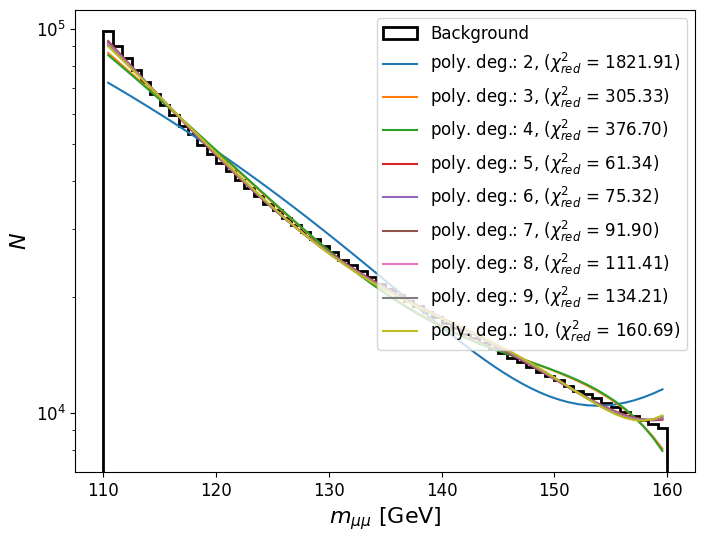

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

bkg_hist = hists["Background"]
plot_simple_histogram(ax, [bkg_hist["centers"], bkg_hist["edges"], bkg_hist["values"], 0.01], lw=2, color="k", label="Background")

for deg, poly_result, chi2_result in zip(poly_degs, poly_results, reduced_chi2_results):
    ax.plot(bin_centers, poly_result, label=f"poly. deg.: {deg}, ($\\chi^2_{{red}}$ = {chi2_result:.2f})")

ax.set_xlabel(r"$m_{\mu\mu}$ [GeV]", fontsize=16)
ax.set_ylabel("$N$", fontsize=16)

ax.legend()
ax.set_yscale("log")

In [ ]:
def potencna_funkcija(x, a, b):
    return a * x**b


def eksponentna_funkcija(x, a1, a2, b1, b2):
    return a1 * np.exp(-b1*x) + a2 * np.exp(-b2*x)


def dijet_funkcija(x, a, d, c, b1, b2):
    return a * (1 - x**d)**c * x**(b1 + b2 * np.log(x))


def eksponent_polinoma(x, a, b1, b2, b3):
    return a * np.exp(b1 * x + b2 * x**2 + b3 * x**3)


def cms_fit_function(m, a_1, a_2, a_3):
    m_Z, g_Z = 91.1876, 2.4952
    return np.exp(a_2 * m + a_3 * m**2) / ((m - m_Z) ** a_1 + (0.5 * g_Z) ** a_1)

C:\Users\tadej\AppData\Local\Temp\ipykernel_16928\14563736.py:2: RuntimeWarning: overflow encountered in power
  return a * x**b
C:\Users\tadej\AppData\Local\Temp\ipykernel_16928\14563736.py:2: RuntimeWarning: overflow encountered in multiply
  return a * x**b
C:\Users\tadej\AppData\Local\Temp\ipykernel_16928\14563736.py:10: RuntimeWarning: overflow encountered in power
  return a * (1 - x**d)**c * x**(b1 + b2 * np.log(x))
C:\Users\tadej\AppData\Local\Temp\ipykernel_16928\14563736.py:10: RuntimeWarning: invalid value encountered in power
  return a * (1 - x**d)**c * x**(b1 + b2 * np.log(x))
C:\Users\tadej\AppData\Local\Temp\ipykernel_16928\3841524476.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_dijet, pcov_dijet = curve_fit(dijet_funkcija, xdata, ydata, sigma=yerrors,


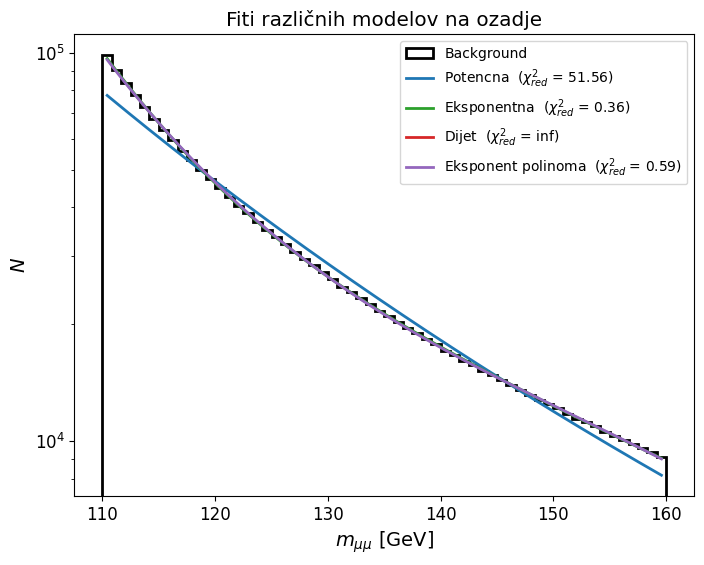

In [ ]:
# === Pridobimo podatke iz histograma ===
xdata = bkg_hist["centers"]
ydata = bkg_hist["values"]
yerrors = 0.01 * ydata  # ali tvoj realni bkg_hist["errors"]

# === Fit za posamezne funkcije ===
fits = {}

# Potenčna
popt_pot, pcov_pot = curve_fit(potencna_funkcija, xdata, ydata, sigma=yerrors, p0=[1e5, -2])
fits["Potencna"] = (popt_pot, potencna_funkcija)

# Eksponentna (vsota treh)
popt_exp, pcov_exp = curve_fit(eksponentna_funkcija, xdata, ydata, sigma=yerrors,
                               p0=[1e5, 1e5, 0.01, 0.01],
                               maxfev=100000)
fits["Eksponentna"] = (popt_exp, eksponentna_funkcija)

# Dijet
popt_dijet, pcov_dijet = curve_fit(dijet_funkcija, xdata, ydata, sigma=yerrors,
                                   p0=[1e3, 0.1, 100, 100, 100], maxfev=10000)
fits["Dijet"] = (popt_dijet, dijet_funkcija)

# Eksponent polinoma
popt_exppoly, pcov_exppoly = curve_fit(eksponent_polinoma, xdata, ydata, sigma=yerrors,
                                       p0=[1e5, -0.01, 1e-5, -1e-8],
                                       maxfev=10000)
fits["Eksponent polinoma"] = (popt_exppoly, eksponent_polinoma)

# CMS fit function
popt_cms, pcov_cms = curve_fit(cms_fit_function, xdata, ydata, sigma=yerrors,
                                       p0=np.array([1.0, 1.0, 1.0]) * 1e-3,
                                       maxfev=10000)
fits["Cms fit"] = (popt_cms, cms_fit_function)


# === Izračun χ²_reduced za vsakega ===
chi2_values = {}
for name, (params, func) in fits.items():
    y_model = func(xdata, *params)
    chi2 = np.sum(((ydata - y_model) / yerrors) ** 2)
    dof = len(ydata) - len(params)
    chi2_red = chi2 / dof if dof > 0 else np.nan
    chi2_values[name] = chi2_red


# === Risanje ===
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
plot_simple_histogram(ax, [bkg_hist["centers"], bkg_hist["edges"], bkg_hist["values"], 0.01],
                      lw=2, color="k", label="Background")
ax.set_yscale("log")
ax.set_xlabel(r"$m_{\mu\mu}$ [GeV]", fontsize=14)
ax.set_ylabel("$N$", fontsize=14)
ax.set_title("Fiti različnih modelov na ozadje")

# Narišemo vse fite
x_fit = np.linspace(np.min(xdata), np.max(xdata), 1000)

colors = {
    "Potencna": "tab:blue",
    "Eksponentna": "tab:green",
    "Dijet": "tab:red",
    "Eksponent polinoma": "tab:purple"
}

for name, (params, func) in fits.items():
    y_fit = func(x_fit, *params)
    chi2_red = chi2_values[name]
    ax.plot(x_fit, y_fit, color=colors[name], lw=2,
            label=f"{name}  ($\\chi^2_{{red}}$ = {chi2_red:.2f})")

ax.legend(fontsize=10)
plt.show()